In [3]:
import os
os.chdir("../../")

import torch
import numpy as np
import matplotlib.pyplot as plt

from models.cev_class import Cev
from torch.distributions import Uniform

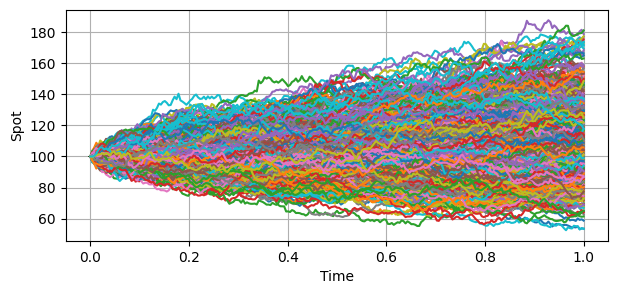

In [2]:
torch.manual_seed(42)

dt = torch.tensor(1 / 252)
T = 1.0
S0 = torch.tensor(100.0)

mu_true = torch.tensor(0.1)
delta_true = torch.tensor(2.0)
beta_true = torch.tensor(1.0)

cev_model = Cev(mu_true, delta_true, beta_true)
#params = torch.tensor([S0, mu, delta, beta])

S = cev_model.simulate(S0, dt, T, M=1000)

plt.figure(figsize=(7,3))
plt.plot(torch.linspace(0, T, len(S)), S)
plt.xlabel('Time')
plt.ylabel('Spot')
plt.grid()
plt.show()

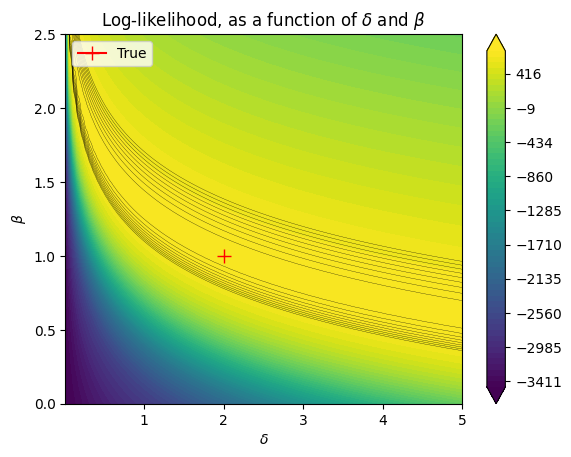

In [18]:
t = S.shape[0] - 1
window = 200
spot = S[:, 0]

deltas = torch.linspace(0.01, 5.0, 100)
betas = torch.linspace(0.0, 2.5, 100)
deltas, betas = torch.meshgrid(deltas, betas)
log_likelihood = torch.zeros(size=(100, 100))
for i in range(deltas.shape[0]):
    for j in range(deltas.shape[1]):
        model = Cev(mu_true, deltas[i, j], betas[i, j])
        log_likelihood[i, j] = model.forward(spot, t, delta_t=dt, window=t)

min = torch.min(log_likelihood).detach()
max = torch.max(log_likelihood).detach()
levels = np.linspace(min, max, 60)
contour = plt.contourf(deltas, betas, log_likelihood.detach(), levels=levels, cmap='viridis', extend='both')
plt.colorbar(contour)
levels = np.linspace(max - 100, max, 10)
contour_line = plt.contour(deltas, betas, log_likelihood.detach(), levels=levels, colors='black', linewidths=0.2)


marker_plot = plt.plot(delta_true.item(), beta_true.item(), marker='+', color='red', markersize=10, label='True')
plt.legend(handles=marker_plot, loc='upper left')

plt.xlabel(r'$\delta$')
plt.ylabel(r'$\beta$')
plt.title(r'Log-likelihood, as a function of $\delta$ and $\beta$')
plt.show()

In [19]:
torch.manual_seed(42)
t = S.shape[0] - 1
window = 200

n_paths = S.shape[1]
n_params = 2
stats = {
    "mle": torch.zeros(size=(n_paths, n_params)),
    "max_value": torch.zeros(size=(n_paths,)),
    "n_it": torch.zeros(size=(n_paths,)),
    "no_convergence": 0,
}

max_it = 1000
grad_norm_threshold = 0.1
for i in range(n_paths):
    mu = mu_true

    delta = Uniform(low=0.01, high=5).sample()
    beta = Uniform(low=0.0, high=2.5).sample()
    model = Cev(mu, delta, beta)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, maximize=True)
    spot_prices = S[:, i]
    for j in range(max_it):
        optimizer.zero_grad()
        loss = model.forward(spot_prices, t=t, delta_t=dt, window=window)
        loss.backward()
        total_norm = torch.norm(torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None]))
        
        #print(f"Epoch {j}, Loss: {loss.item():.3f}, Grad Norm: {total_norm.item():.3f}")
        if total_norm < grad_norm_threshold:
            stats["n_it"][i] = j
            break
        if j == max_it - 1:
            stats["n_it"][i] = j
            stats["no_convergence"] += 1
            #print("Maximum iteration reached.")
        optimizer.step()
    
    params = model.get_params()
    stats["mle"][i, 0] = params[0]
    stats["mle"][i, 1] = params[1]

    model = Cev(mu_true, params[0], params[1])
    value = model.forward(spot_prices, t=t, delta_t=dt, window=window)
    stats["max_value"][i] = value


In [23]:
mean = torch.mean(stats["mle"], dim=0)
std = torch.std(stats["mle"], dim=0)
avg_it = torch.mean(stats["n_it"])
n_no_conv = stats["no_convergence"]

true_params = torch.tensor([delta_true.item(), beta_true.item()])
avg_distance_to_argmax = torch.mean(torch.norm(stats["mle"] - true_params))

true_max_value = Cev(mu_true, delta_true, beta_true).forward(spot_prices, t=t, delta_t=dt, window=window).item()
avg_distance_to_max = torch.mean(torch.abs(stats["max_value"] - true_max_value)).item()

print(f"Average MLE: delta:{mean[0].item():.3f}, beta:{mean[1].item():.3f}")
print(f"Std MLE: delta:{std[0].item():.3f}, beta:{std[1].item():.3f}")
print(f"Average distance to true parameter: {avg_distance_to_argmax.item():.3f}")
print(f"Average relative error to the true maximum: {((true_max_value - avg_distance_to_max) / true_max_value):.3f}")
print(f"Average number of iteration to convergence {avg_it.item():.3f}")
print(f"Number of parameters where GD didn't converge: {n_no_conv} / {n_paths}")

Average MLE: delta:3.626, beta:0.969
Std MLE: delta:3.631, beta:0.557
Average distance to true parameter: 126.974
Average relative error to the true maximum: 0.937
Average number of iteration to convergence 662.825
Number of parameters where GD didn't converge: 572 / 1000
